In [1]:
from torch.utils.data import Dataset
import numpy as np
import os
import torch
import random
import collections


class DIRC_Dataset(Dataset):

    def __init__(self,data,stats={"x_max": 892,"x_min":0,"y_max":292,"y_min":0,"time_max":500.00,"time_min":0.0}):
        self.data = data
        self.stats = stats

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        # ['EventID','PDG','NHits','BarID','P','Theta','Phi','X','Y','Z',
        # 'pmtID','pixelID','channel'','leadTime']

        # Get the sample
        data = self.data[idx]
        
        PID = data['PDG']
        barID = data['BarID']
        barX = data['X']
        barY = data['Y']
        pmtID = np.array(data['pmtID'])
        event_num = data['EventID']
        o_box = pmtID//108
        if len(o_box) == 0:
            return 0,0,0,0,-1

        if o_box[0] == 1:
            pmtID -= 108

        if len(np.unique(o_box)) != 1:
            print(np.unique(o_box))

        pixelID = np.array(data['pixelID'])

        row = (pmtID//18) * 8 + pixelID//8
        col = (pmtID%18) * 8 + pixelID%8

        time = np.array(data['leadTime'])

        pos_time = np.where((time > 0) & (time < 500))[0]
        row = row[pos_time]
        col = col[pos_time]
        time = time[pos_time]
        pmtID = pmtID[pos_time]
        
        assert len(row) == len(time)

        x = col * 6 + (pmtID % 18) * 2 + 3# + np.random.uniform(-3,3)
        y = row * 6 + (pmtID // 18) * 2 + 3# + np.random.uniform(-3,3,random)

        if abs(PID) == 211: # 211 is Pion from rho decay
            PID = 1
        elif abs(PID) == 321: # 321 is Kaon from phi decay
            PID = 0
        else:
            return 0,0,0,0,-1
            #print("Ambiguous final state {0}. Check event {1}".format(PID,idx))
            
        barID = np.ones_like(pmtID) * barID
        barX = np.ones_like(pmtID) * barX
        barY = np.ones_like(pmtID) * barY
        
        metadata = np.concatenate([np.c_[barID],np.c_[barX],np.c_[barY]],axis=1)
    
        cond = np.array([data['P'],data['Theta'],data['Phi']])
        cond = cond.reshape(1,-1).repeat(len(x),0)
        hits = np.concatenate([np.c_[x],np.c_[y],np.c_[time]],axis=1)
        return hits,cond,metadata,event_num,1


C:\Users\James\.conda\envs\ptorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Making .pkl files for DLL

Just reuse the pion code for kaons. Makes it simpler.

In [7]:
import numpy as np

all_pions = np.load("path/to/pions_or_kaons.pkl",allow_pickle=True)

In [8]:
Nt = int(0.7 * len(all_pions))
train_pions = all_pions[:Nt]
test_val = all_pions[Nt:]

Nv = int(0.5 * len(test_val))
val_pions = test_val[Nv:]
test_pions = test_val[:Nv]

print(len(train_pions) + len(test_pions) + len(val_pions) - len(all_pions))
print(len(train_pions), len(test_pions), len(val_pions))

0
980478 210102 210103


In [4]:
len(train_pions),len(test_pions),len(val_pions)

(1297003, 277929, 277930)

In [8]:
len(train_pions),len(test_pions),len(val_pions)

(1297003, 277929, 277930)

In [9]:
import pickle
with open(r"/Cherenkov/Data/Training_Kaons_ParticleGun.pkl","wb") as file:
    pickle.dump(train_pions,file)
    
with open(r"/Cherenkov/Data/Validation_Kaons_ParticleGun.pkl","wb") as file:
    pickle.dump(val_pions,file)
    
with open(r"/Cherenkov/Data/Testing_Kaons_ParticleGun.pkl","wb") as file:
    pickle.dump(test_pions,file)

In [10]:
del train_pions,val_pions,test_pions

# Making .csv files for training of NF

In [23]:
import numpy as np
rho_train_ = np.load(r"/Cherenkov/Data/Training_Kaons_ParticleGun.pkl",allow_pickle=True)
rho_test_ = np.load(r"/Cherenkov/Data/Validation_Kaons_ParticleGun.pkl",allow_pickle=True)
rho_val_ = np.load("/Cherenkov/Data/Testing_Kaons_ParticleGun.pkl",allow_pickle=True)

Insert the different train,validation or testing arrays into the dataset below.

In [9]:
dataset = DIRC_Dataset(rho_test_)
print(len(dataset))

100319


In [10]:
hits = []
conditions = []
metadata = []
events_dict = []
eventIDs = []

for i in range(len(dataset)):
    if i % 100000 == 0:
        print(i)
    h,cond,meta,eventID,status = dataset.__getitem__(i)
    
    if status == -1:
        print('Rejection.')
        continue
#     dicte = {"EventID":eventID,"hits":h,"conditions":cond,"meta":meta}
#     events_dict.append(dicte)
    hits.append(h)
    conditions.append(cond)
    metadata.append(meta)
    eventIDs.append(eventID * np.ones_like(cond[:,0]))

0
100000


In [11]:
import pandas as pd
def to_csv(file_path,hits,conds,meta):
    hits = np.concatenate(hits)
    conds = np.concatenate(conds)
    meta = np.concatenate(meta)
    print(hits.shape,conds.shape,meta.shape)
    hits_frame = pd.DataFrame(np.concatenate([hits,conds,meta],axis=1),columns=["x","y","time","P","theta","phi","barID","barX","barY"])
    print("Max")
    print(hits_frame.max())
    print(" ")
    print("Min")
    print(hits_frame.min())
    hits_frame.to_csv(file_path,sep=',',index=None)

Convert to .csv files for training the normalizing flows.

In [ ]:
to_csv("/Cherenkov/Data/Training_Kaons_ParticleGun.csv",hits,conditions,metadata)

(5667388, 3) (5667388, 3) (5667388, 3)
Max
x        895.000000
y        295.000000
time     371.977000
P          8.499129
theta     11.430980
phi      174.859467
barID     47.000000
barX     101.010056
barY     100.306717
dtype: float64
 
Min
x          3.000000
y          3.000000
time       0.000294
P          0.950079
theta      1.021368
phi     -174.550217
barID      0.000000
barX    -104.618286
barY    -101.957977
dtype: float64


# Make presmeared training sets:

In [39]:
import pandas as pd

df = pd.read_csv("/Cherenkov/Data/Training_Kaons_ParticleGun.csv",sep=',',index_col=None)
df

,x,y,time,P,theta,phi,barID,barX,barY
0,71.0,95.0,72.3105,4.761747,3.368834,26.565176,25.0,27.002846,13.204746
1,77.0,109.0,29.9083,4.761747,3.368834,26.565176,25.0,27.002846,13.204746
2,127.0,65.0,31.3305,4.761747,3.368834,26.565176,25.0,27.002846,13.204746
3,145.0,133.0,50.8152,4.761747,3.368834,26.565176,25.0,27.002846,13.204746
4,133.0,145.0,67.6548,4.761747,3.368834,26.565176,25.0,27.002846,13.204746
...,...,...,...,...,...,...,...,...,...
69255840,871.0,145.0,69.6319,5.123284,2.806493,-47.433094,2.0,17.361284,-18.314543
69255841,889.0,115.0,79.2094,5.123284,2.806493,-47.433094,2.0,17.361284,-18.314543
69255842,895.0,109.0,129.1560,5.123284,2.806493,-47.433094,2.0,17.361284,-18.314543
69255843,815.0,189.0,48.4602,5.123284,2.806493,-47.433094,2.0,17.361284,-18.314543


array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>,
        <AxesSubplot:title={'center':'time'}>],
       [<AxesSubplot:title={'center':'P'}>,
        <AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'phi'}>],
       [<AxesSubplot:title={'center':'barID'}>,
        <AxesSubplot:title={'center':'barX'}>,
        <AxesSubplot:title={'center':'barY'}>]], dtype=object)

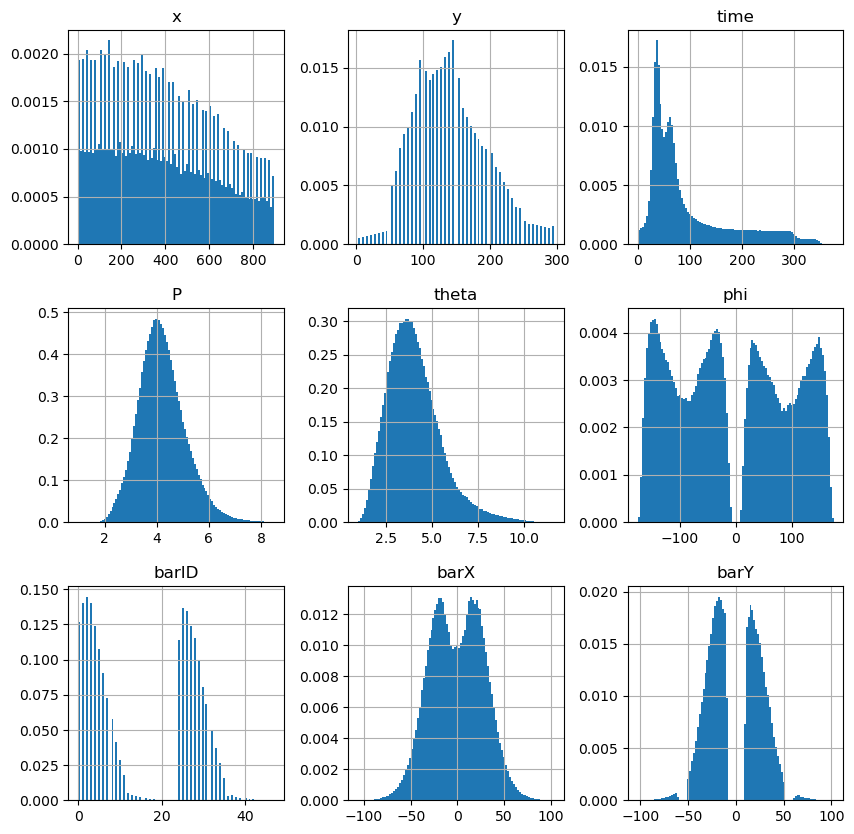

In [40]:
df.hist(bins=100,density=True,figsize=(10,10))

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>,
        <AxesSubplot:title={'center':'time'}>],
       [<AxesSubplot:title={'center':'P'}>,
        <AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'phi'}>],
       [<AxesSubplot:title={'center':'barID'}>,
        <AxesSubplot:title={'center':'barX'}>,
        <AxesSubplot:title={'center':'barY'}>]], dtype=object)

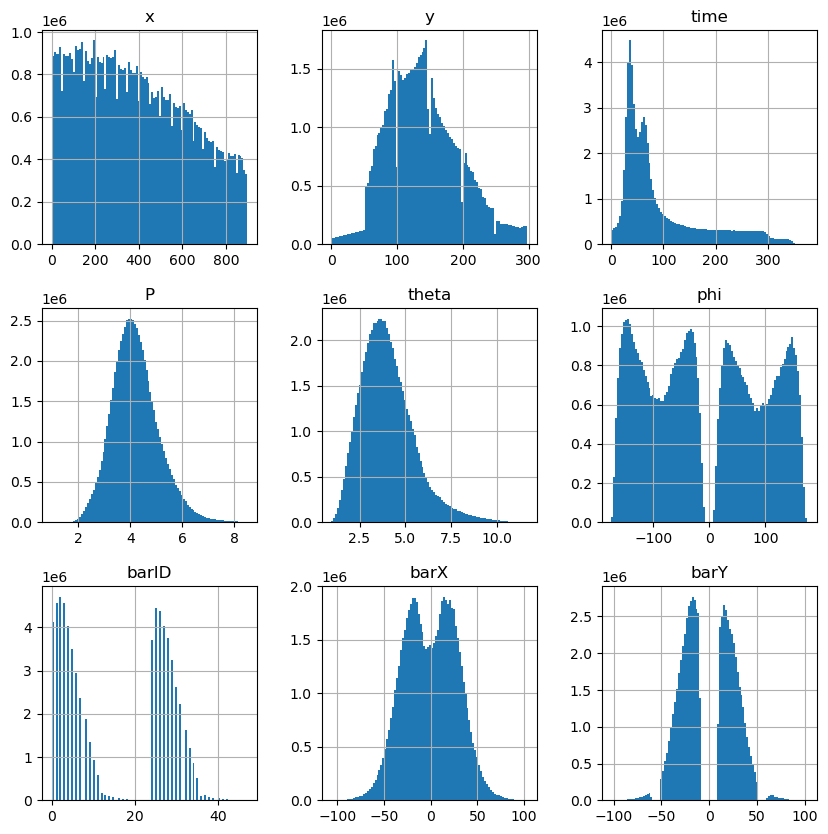

In [41]:
import numpy as np

df['x'] = df['x'] + np.random.uniform(-3,3,size=df['x'].to_numpy().shape)
df['y'] = df['y'] + np.random.uniform(-3,3,size=df['y'].to_numpy().shape)
df.hist(figsize=(10,10),bins=100)

In [43]:
df.to_csv("/Cherenkov/Data/Training_Kaons_ParticleGun_Smeared.csv",sep=',',index=None)

In [42]:
# Kaons
df.max(),df.min()

(x        897.999988
 y        297.999942
 time     375.379000
 P          8.499743
 theta     11.624766
 phi      174.588837
 barID     47.000000
 barX     103.279648
 barY     102.391663
 dtype: float64,
 x          0.000005
 y          0.000016
 time       0.000002
 P          0.978703
 theta      0.973956
 phi     -174.718369
 barID      0.000000
 barX    -106.338310
 barY    -102.433014
 dtype: float64)

In [38]:
# Pions
df.max(),df.min()

(x        897.999991
 y        297.999994
 time     373.676000
 P          8.499416
 theta     11.626334
 phi      174.691574
 barID     47.000000
 barX     108.075714
 barY     102.214432
 dtype: float64,
 x        2.471182e-07
 y        9.369300e-07
 time     1.306530e-05
 P        1.035606e+00
 theta    9.571560e-01
 phi     -1.746061e+02
 barID    0.000000e+00
 barX    -1.054531e+02
 barY    -1.027125e+02
 dtype: float64)

In [ ]:
{"x_max": 898,"x_min":0,"y_max":298,"y_min":0,"time_max":375.5,"time_min":0.0,"P_max":8.5 ,"P_min":0.97 ,"theta_max": 11.63,"theta_min": 0.96,"phi_max": 174.69, "phi_min":-174.72}

# Making files in a format for generation

In [2]:
import numpy as np
import pandas as pd
import random
from torch.utils.data import Dataset
import torch

class DLL_Dataset(Dataset):
    # Real Max: 376.82, Min: 1.901769999999999e-05
    def __init__(self,file_path,stats={"x_max": 898,"x_min":0,"y_max":298,"y_min":0,"time_max":500.00,"time_min":0.0},time_cuts=None,log_time=False):
        self.data = np.load(file_path,allow_pickle=True) # Useful for testing
        self.n_photons = 250
        self.stats = stats
        self.conditional_maxes = np.array([8.5,11.63,175.5])
        self.conditional_mins = np.array([0.95,0.90,-176.])
        self.time_cuts = time_cuts
        if self.time_cuts is not None:
            print('Rejecting photons with time > {0}'.format(self.time_cuts))
        self.log_time = log_time
        if self.log_time:
            print('Using log time.')
            self.stats['time_max'] = 5.931767619849855
            self.stats['time_min'] = -10.870140433500834

    def __len__(self):
        return len(self.data)

    def scale_data(self,hits,stats):
        x = hits[:,0]
        y = hits[:,1]
        time = hits[:,2]
        x = 2.0 * (x - stats['x_min'])/(stats['x_max'] - stats['x_min']) - 1.0
        y = 2.0 * (y - stats['y_min'])/(stats['y_max'] - stats['y_min']) - 1.0
        time = 2.0 * (time - stats['time_min'])/(stats['time_max'] - stats['time_min']) - 1.0
        return np.concatenate([np.c_[x],np.c_[y],np.c_[time]],axis=1)

    def __getitem__(self, idx):

        particle = self.data[idx]
        pmtID = np.array(particle['pmtID'])
        o_box = pmtID//108
        if o_box[0] == 1:
            pmtID -= 108

        pixelID = np.array(particle['pixelID'])
        barID = particle['BarID']
        barX = particle['X']
        P,theta,phi = particle['P'],particle['Theta'],particle['Phi']
        

        row = (pmtID//18) * 8 + pixelID//8
        col = (pmtID%18) * 8 + pixelID%8

        time = np.array(particle['leadTime'])

        pos_time = np.where((time > 0) & (time < 500))[0]
        row = row[pos_time]
        col = col[pos_time]
        time = time[pos_time]

        pmtID = pmtID[pos_time]

        assert len(row) == len(time)

        x = col * 6. + (pmtID % 18) * 2. + 3.
        y = row * 6. + (pmtID // 18) * 2. + 3.

        hits = np.concatenate([np.c_[x],np.c_[y],np.c_[time]],axis=1)
        conds = np.array([particle['P'],particle['Theta'],particle['Phi']])
        conds = conds.reshape(1,-1).repeat(len(x),0)
        unscaled_conds = conds.copy()

        if self.log_time:
            hits[:,2] = np.log(hits[:,2])


        if self.time_cuts is not None:
            idx = np.where(hits[:,2] < self.time_cuts)[0]
            hits = hits[idx]
            conds = conds[idx]

        
        PID = np.array(particle['PDG'])
        n_hits = len(hits)
        
        conds = (conds - self.conditional_maxes) / (self.conditional_maxes - self.conditional_mins)
    
        return hits,conds,unscaled_conds,n_hits,P,theta,phi,barID,barX


C:\Users\James\.conda\envs\ptorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
all_data = DLL_Dataset(r"/Cherenkov/Data/All_Kaons_ParticleGun.pkl")

In [12]:
hit_vec = []
cond_vec = []
unscaled_cond_vec = []
n_hits_vec = []
P_vec = []
theta_vec = []
phi_vec = []
barID_vec = []
barX_vec = []
data_dict = {}

for i in range(len(all_data)):
    hits,conds,unscaled_conds,n_hits,P,theta,phi,barID,barX = all_data.__getitem__(i)
    hit_vec.append(hits)
    cond_vec.append(conds)
    unscaled_cond_vec.append(unscaled_conds)
    n_hits_vec.append(n_hits)
    P_vec.append(P)
    theta_vec.append(theta)
    phi_vec.append(phi)
    barID_vec.append(barID)
    barX_vec.append(barX)

In [13]:
data_dict['NHits'] = np.array(n_hits_vec)
data_dict['P'] = np.array(P_vec)
data_dict['theta'] = np.array(theta_vec)
data_dict['phi'] = np.array(phi_vec)
data_dict['BarID'] = np.array(barID_vec)
data_dict['X'] = np.array(barX_vec)
data_dict['Hits'] = hit_vec
data_dict['conds'] = cond_vec

for key in list(data_dict.keys()):
    print(key,len(data_dict[key]))

NHits 1502032
P 1502032
theta 1502032
phi 1502032
BarID 1502032
X 1502032
Hits 1502032
conds 1502032


In [54]:
max_t = 0

for i in range(len(data_dict['Hits'])):
    t = data_dict['Hits'][i][:,2].max()
    if t > max_t:
        max_t = t
        
print("Pions: ",max_t)

Pions:  373.676


In [59]:
max_t = 0

for i in range(len(data_dict['Hits'])):
    t = data_dict['Hits'][i][:,2].max()
    if t > max_t:
        max_t = t
        
print("Kaons: ",max_t)

Kaons:  375.379


In [14]:
import pickle
with open(r"Cherenkov/Data/TrackWiseGenerations_Pions.pkl",'wb') as file:
    pickle.dump(data_dict,file)